In [1]:
import numpy as np
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

#### **Creating a Neural Network with TfidfVectorizer and Pytorch**

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading the Tokenized tweets**

In [3]:
tweets_train_tokenized = pd.read_csv('csvs/tweets_train_tokens.csv', index_col=False)
tweets_train_tokenized_message = pd.Series(tweets_train_tokenized.message)
# Converting Panda series into Unicode datatype as required by vectorizers
tweets = tweets_train_tokenized_message.astype('U').values
tweets

array(['arirang simply kpop kim hyung jun cross ha yeong playback',
       'read politico article donald trump running mate tom brady list likely choice',
       'type bazura project google image image photo dad glenn moustache whatthe',
       ..., 'bring dunkin iced coffee tomorrow hero',
       'currently holiday portugal come home tomorrow poland tuesday holocaust memorial trip',
       'ladykiller saturday aternoon'], dtype=object)

**B. Loading our target labels**

In [4]:
tweets_train_y = pd.read_csv('csvs/tweets_train_y.csv', index_col=False)
tweets_train_y = pd.Series(tweets_train_y['0'])
tweets_train_y = tweets_train_y.values
tweets_train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [5]:
np.unique(tweets_train_y)

array([0, 1, 2], dtype=int64)

**C. Train-test Split**

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(tweets, tweets_train_y, test_size=0.2, random_state=21, stratify=tweets_train_y)
print('# Train data samples:', X_full_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_full_train.shape[0] == y_full_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 39740
# Test data samples: 9935


**D. Converting input texts to vectors using TfidfVectorizer**

In [7]:
# you can also specify ngram_range
# you can also choose the max_features parameter, which just includes those features with the top frequencies specified by the max_features i.e.
# max_features = 7500, includes only those top 7500 features with the highest frequencies
# min_df includes only words which appear at least twice in every document
# ngram_range=(1,2)
tfidf = TfidfVectorizer(min_df=2, max_features=5000, ngram_range=(1,2))
X_full_train_vec = tfidf.fit_transform(X_full_train).toarray()
X_full_train_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
X_test_vec = tfidf.transform(X_test).toarray()
X_test_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**E. Splitting train set for validation**

In [9]:
X_train_vec, X_val_vec, y_train_vec, y_val_vec = train_test_split(X_full_train_vec, y_full_train, test_size=0.2, random_state=21)

assert X_val_vec.shape[0] == y_val_vec.shape[0]
assert X_train_vec.shape[0] == y_train_vec.shape[0]

print('Shape of validation set:',X_val_vec.shape)

Shape of validation set: (7948, 5000)


**F. Converting features and targets into Tensors**

In [10]:
X_train_vec = torch.from_numpy(X_train_vec).type(torch.float)
y_train_vec = torch.from_numpy(y_train_vec).type(torch.LongTensor)

X_val_vec = torch.from_numpy(X_val_vec).type(torch.float)
y_val_vec = torch.from_numpy(y_val_vec).type(torch.LongTensor)

In [11]:
print(f'X_train_vec shape: {X_train_vec.shape}, y_train_vec shape: {y_train_vec.shape}')

X_train_vec shape: torch.Size([31792, 5000]), y_train_vec shape: torch.Size([31792])


**G. Creating our Neural Network Architecture** 

In [12]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
    
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [13]:
# Create an instance of the model and send it to target device
model_0 = NeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_0

NeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

**H. Neural Network Hyperparameters**

In [14]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)
batch_size = 128

In [15]:
# Test structure of model
# predictions_before are the logits, or the raw, untrained output of the model
predictions_before = model_0.forward(torch.Tensor(X_val_vec).float())
predictions_before

tensor([[-0.0839,  0.0408,  0.0756],
        [-0.0796,  0.0425,  0.0757],
        [-0.0807,  0.0413,  0.0761],
        ...,
        [-0.0863,  0.0464,  0.0731],
        [-0.0804,  0.0430,  0.0836],
        [-0.0762,  0.0458,  0.0762]], grad_fn=<AddmmBackward0>)

In [16]:
y_pred_probs = torch.softmax(predictions_before, dim=1)
y_pred_probs

tensor([[0.3025, 0.3427, 0.3548],
        [0.3032, 0.3426, 0.3542],
        [0.3031, 0.3424, 0.3545],
        ...,
        [0.3017, 0.3445, 0.3538],
        [0.3022, 0.3418, 0.3560],
        [0.3035, 0.3429, 0.3535]], grad_fn=<SoftmaxBackward0>)

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value `using torch.argmax()`.

In [17]:
print(torch.argmax(y_pred_probs, dim=1))

tensor([2, 2, 2,  ..., 2, 2, 2])


You can see the output of torch.argmax() returns 0, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 0.

Of course, right now this is just random guessing so it's got a 33% chance of being right (since there's three classes). But we can improve those chances by training the model.

In [18]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

**I. Training the Network**

In [19]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_train_vec, y=y_train_vec)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_0,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_0.state_dict() }
torch.save(state, "./torch_models/model_0.pth")

Epoch: 0


100%|██████████| 249/249 [00:02<00:00, 109.31it/s, loss=1.04]


Ave Loss: 1.06134192723347
Epoch: 1


100%|██████████| 249/249 [00:01<00:00, 137.77it/s, loss=0.995]


Ave Loss: 1.0213390239271294
Epoch: 2


100%|██████████| 249/249 [00:01<00:00, 139.96it/s, loss=0.953]


Ave Loss: 0.981259581793743
Epoch: 3


100%|██████████| 249/249 [00:01<00:00, 133.67it/s, loss=0.913]


Ave Loss: 0.9436625996267939
Epoch: 4


100%|██████████| 249/249 [00:01<00:00, 141.23it/s, loss=0.872]


Ave Loss: 0.9076510557687905
Epoch: 5


100%|██████████| 249/249 [00:01<00:00, 140.56it/s, loss=0.833]


Ave Loss: 0.8742031629784519
Epoch: 6


100%|██████████| 249/249 [00:01<00:00, 132.30it/s, loss=0.796]


Ave Loss: 0.8442876382046435
Epoch: 7


100%|██████████| 249/249 [00:01<00:00, 135.98it/s, loss=0.761]


Ave Loss: 0.818062246803299
Epoch: 8


100%|██████████| 249/249 [00:01<00:00, 137.84it/s, loss=0.729]


Ave Loss: 0.7951815729160385
Epoch: 9


100%|██████████| 249/249 [00:01<00:00, 141.60it/s, loss=0.699]


Ave Loss: 0.7751705076799814
Epoch: 10


100%|██████████| 249/249 [00:01<00:00, 132.59it/s, loss=0.672]


Ave Loss: 0.757583117628672
Epoch: 11


100%|██████████| 249/249 [00:01<00:00, 142.12it/s, loss=0.648]


Ave Loss: 0.7420256262323464
Epoch: 12


100%|██████████| 249/249 [00:01<00:00, 136.21it/s, loss=0.625]


Ave Loss: 0.7281820972760519
Epoch: 13


100%|██████████| 249/249 [00:01<00:00, 135.81it/s, loss=0.604]


Ave Loss: 0.7158013146565142
Epoch: 14


100%|██████████| 249/249 [00:01<00:00, 144.18it/s, loss=0.585]


Ave Loss: 0.7046787272016686
Epoch: 15


100%|██████████| 249/249 [00:01<00:00, 134.56it/s, loss=0.568]


Ave Loss: 0.6946447611333855
Epoch: 16


100%|██████████| 249/249 [00:01<00:00, 135.84it/s, loss=0.552]


Ave Loss: 0.6855594712088865
Epoch: 17


100%|██████████| 249/249 [00:01<00:00, 140.08it/s, loss=0.537]


Ave Loss: 0.6773033805161595
Epoch: 18


100%|██████████| 249/249 [00:01<00:00, 139.78it/s, loss=0.523]


Ave Loss: 0.6697713625000183
Epoch: 19


100%|██████████| 249/249 [00:01<00:00, 150.53it/s, loss=0.51] 


Ave Loss: 0.6628748918154154
Epoch: 20


100%|██████████| 249/249 [00:01<00:00, 149.19it/s, loss=0.498]


Ave Loss: 0.6565412013645632
Epoch: 21


100%|██████████| 249/249 [00:01<00:00, 150.27it/s, loss=0.487]


Ave Loss: 0.6507086441459426
Epoch: 22


100%|██████████| 249/249 [00:01<00:00, 139.74it/s, loss=0.477]


Ave Loss: 0.6453190825311056
Epoch: 23


100%|██████████| 249/249 [00:01<00:00, 134.85it/s, loss=0.467]


Ave Loss: 0.6403246511177845
Epoch: 24


100%|██████████| 249/249 [00:01<00:00, 153.37it/s, loss=0.458]


Ave Loss: 0.635683743230789
Epoch: 25


100%|██████████| 249/249 [00:01<00:00, 155.73it/s, loss=0.449]


Ave Loss: 0.6313594844207228
Epoch: 26


100%|██████████| 249/249 [00:01<00:00, 142.53it/s, loss=0.441]


Ave Loss: 0.6273205555586451
Epoch: 27


100%|██████████| 249/249 [00:01<00:00, 147.36it/s, loss=0.434]


Ave Loss: 0.6235388615523955
Epoch: 28


100%|██████████| 249/249 [00:01<00:00, 145.53it/s, loss=0.427]


Ave Loss: 0.6199903050100947
Epoch: 29


100%|██████████| 249/249 [00:01<00:00, 145.75it/s, loss=0.42] 


Ave Loss: 0.6166522391589291
Epoch: 30


100%|██████████| 249/249 [00:01<00:00, 134.88it/s, loss=0.413]


Ave Loss: 0.6135061253984291
Epoch: 31


100%|██████████| 249/249 [00:01<00:00, 151.54it/s, loss=0.407]


Ave Loss: 0.6105366412654938
Epoch: 32


100%|██████████| 249/249 [00:01<00:00, 149.52it/s, loss=0.402]


Ave Loss: 0.6077282809349428
Epoch: 33


100%|██████████| 249/249 [00:01<00:00, 151.92it/s, loss=0.396]


Ave Loss: 0.6050675763901936
Epoch: 34


100%|██████████| 249/249 [00:01<00:00, 148.46it/s, loss=0.391]


Ave Loss: 0.6025415737944914
Epoch: 35


100%|██████████| 249/249 [00:01<00:00, 141.85it/s, loss=0.386]


Ave Loss: 0.6001400625609968
Epoch: 36


100%|██████████| 249/249 [00:01<00:00, 150.42it/s, loss=0.382]


Ave Loss: 0.597851758142073
Epoch: 37


100%|██████████| 249/249 [00:01<00:00, 151.45it/s, loss=0.377]


Ave Loss: 0.595669459985442
Epoch: 38


100%|██████████| 249/249 [00:01<00:00, 150.68it/s, loss=0.373]


Ave Loss: 0.5935849027940069
Epoch: 39


100%|██████████| 249/249 [00:01<00:00, 151.23it/s, loss=0.369]


Ave Loss: 0.5915918992944511
Epoch: 40


100%|██████████| 249/249 [00:01<00:00, 150.65it/s, loss=0.365]


Ave Loss: 0.5896823531891926
Epoch: 41


100%|██████████| 249/249 [00:01<00:00, 149.50it/s, loss=0.362]


Ave Loss: 0.5878508517062329
Epoch: 42


100%|██████████| 249/249 [00:01<00:00, 148.94it/s, loss=0.358]


Ave Loss: 0.5860913672361029
Epoch: 43


100%|██████████| 249/249 [00:01<00:00, 138.97it/s, loss=0.355]


Ave Loss: 0.5844004646123174
Epoch: 44


100%|██████████| 249/249 [00:01<00:00, 140.78it/s, loss=0.352]


Ave Loss: 0.5827720503969843
Epoch: 45


100%|██████████| 249/249 [00:01<00:00, 148.87it/s, loss=0.349]


Ave Loss: 0.5812042277740187
Epoch: 46


100%|██████████| 249/249 [00:01<00:00, 141.75it/s, loss=0.346]


Ave Loss: 0.579692531302272
Epoch: 47


100%|██████████| 249/249 [00:01<00:00, 146.18it/s, loss=0.343]


Ave Loss: 0.578231632230751
Epoch: 48


100%|██████████| 249/249 [00:01<00:00, 136.67it/s, loss=0.341]


Ave Loss: 0.576820157498241
Epoch: 49


100%|██████████| 249/249 [00:01<00:00, 138.87it/s, loss=0.338]


Ave Loss: 0.5754528724285494
Epoch: 50


100%|██████████| 249/249 [00:01<00:00, 148.95it/s, loss=0.336]


Ave Loss: 0.5741296740899603
Epoch: 51


100%|██████████| 249/249 [00:01<00:00, 148.00it/s, loss=0.334]


Ave Loss: 0.5728465941057627
Epoch: 52


100%|██████████| 249/249 [00:01<00:00, 148.05it/s, loss=0.331]


Ave Loss: 0.5716024152485721
Epoch: 53


100%|██████████| 249/249 [00:01<00:00, 147.69it/s, loss=0.329]


Ave Loss: 0.570392949753497
Epoch: 54


100%|██████████| 249/249 [00:01<00:00, 143.04it/s, loss=0.327]


Ave Loss: 0.5692184673973835
Epoch: 55


100%|██████████| 249/249 [00:01<00:00, 151.01it/s, loss=0.326]


Ave Loss: 0.5680740810781119
Epoch: 56


100%|██████████| 249/249 [00:01<00:00, 142.34it/s, loss=0.324]


Ave Loss: 0.5669587867327005
Epoch: 57


100%|██████████| 249/249 [00:01<00:00, 147.86it/s, loss=0.322]


Ave Loss: 0.5658725810098839
Epoch: 58


100%|██████████| 249/249 [00:01<00:00, 149.80it/s, loss=0.32] 


Ave Loss: 0.5648142998237686
Epoch: 59


100%|██████████| 249/249 [00:01<00:00, 150.72it/s, loss=0.319]


Ave Loss: 0.5637809036965351
Epoch: 60


100%|██████████| 249/249 [00:01<00:00, 148.02it/s, loss=0.317]


Ave Loss: 0.5627726802385475
Epoch: 61


100%|██████████| 249/249 [00:01<00:00, 135.52it/s, loss=0.316]


Ave Loss: 0.5617869572945867
Epoch: 62


100%|██████████| 249/249 [00:01<00:00, 140.62it/s, loss=0.314]


Ave Loss: 0.5608220023802485
Epoch: 63


100%|██████████| 249/249 [00:01<00:00, 139.51it/s, loss=0.313]


Ave Loss: 0.5598782806032633
Epoch: 64


100%|██████████| 249/249 [00:01<00:00, 136.97it/s, loss=0.312]


Ave Loss: 0.5589531968875103
Epoch: 65


100%|██████████| 249/249 [00:01<00:00, 139.99it/s, loss=0.31] 


Ave Loss: 0.5580486218373938
Epoch: 66


100%|██████████| 249/249 [00:01<00:00, 144.55it/s, loss=0.309]


Ave Loss: 0.5571612436847994
Epoch: 67


100%|██████████| 249/249 [00:01<00:00, 137.26it/s, loss=0.308]


Ave Loss: 0.5562876247497927
Epoch: 68


100%|██████████| 249/249 [00:01<00:00, 150.51it/s, loss=0.307]


Ave Loss: 0.5554326007883232
Epoch: 69


100%|██████████| 249/249 [00:01<00:00, 144.01it/s, loss=0.306]


Ave Loss: 0.5545906206690164
Epoch: 70


100%|██████████| 249/249 [00:01<00:00, 131.74it/s, loss=0.305]


Ave Loss: 0.5537628900095162
Epoch: 71


100%|██████████| 249/249 [00:02<00:00, 116.78it/s, loss=0.304]


Ave Loss: 0.5529475439504448
Epoch: 72


100%|██████████| 249/249 [00:02<00:00, 113.77it/s, loss=0.303]


Ave Loss: 0.552146054654715
Epoch: 73


100%|██████████| 249/249 [00:02<00:00, 113.57it/s, loss=0.302]


Ave Loss: 0.5513551158598627
Epoch: 74


100%|██████████| 249/249 [00:02<00:00, 116.74it/s, loss=0.301]


Ave Loss: 0.5505761778258894
Epoch: 75


100%|██████████| 249/249 [00:02<00:00, 117.11it/s, loss=0.3]  


Ave Loss: 0.5498059537994814
Epoch: 76


100%|██████████| 249/249 [00:01<00:00, 131.01it/s, loss=0.299]


Ave Loss: 0.5490477264645588
Epoch: 77


100%|██████████| 249/249 [00:02<00:00, 99.58it/s, loss=0.298] 


Ave Loss: 0.5482971690984136
Epoch: 78


100%|██████████| 249/249 [00:02<00:00, 109.45it/s, loss=0.297]


Ave Loss: 0.5475591734709989
Epoch: 79


100%|██████████| 249/249 [00:02<00:00, 122.59it/s, loss=0.297]


Ave Loss: 0.5468275499152371
Epoch: 80


100%|██████████| 249/249 [00:02<00:00, 124.26it/s, loss=0.296]


Ave Loss: 0.5461060306633333
Epoch: 81


100%|██████████| 249/249 [00:02<00:00, 115.32it/s, loss=0.295]


Ave Loss: 0.5453910299812454
Epoch: 82


100%|██████████| 249/249 [00:02<00:00, 110.49it/s, loss=0.294]


Ave Loss: 0.5446828686329256
Epoch: 83


100%|██████████| 249/249 [00:02<00:00, 113.82it/s, loss=0.293]


Ave Loss: 0.5439814288453405
Epoch: 84


100%|██████████| 249/249 [00:02<00:00, 118.72it/s, loss=0.293]


Ave Loss: 0.5432882329306928
Epoch: 85


100%|██████████| 249/249 [00:02<00:00, 116.30it/s, loss=0.292]


Ave Loss: 0.5425987733176434
Epoch: 86


100%|██████████| 249/249 [00:02<00:00, 116.57it/s, loss=0.291]


Ave Loss: 0.5419147565182911
Epoch: 87


100%|██████████| 249/249 [00:02<00:00, 124.33it/s, loss=0.291]


Ave Loss: 0.5412358323254259
Epoch: 88


100%|██████████| 249/249 [00:02<00:00, 119.48it/s, loss=0.29] 


Ave Loss: 0.5405620389195331
Epoch: 89


100%|██████████| 249/249 [00:01<00:00, 127.99it/s, loss=0.289]


Ave Loss: 0.5398923899514608
Epoch: 90


100%|██████████| 249/249 [00:02<00:00, 114.94it/s, loss=0.289]


Ave Loss: 0.5392302545198954
Epoch: 91


100%|██████████| 249/249 [00:02<00:00, 115.19it/s, loss=0.288]


Ave Loss: 0.5385685554709301
Epoch: 92


100%|██████████| 249/249 [00:02<00:00, 119.26it/s, loss=0.288]


Ave Loss: 0.5379141324973968
Epoch: 93


100%|██████████| 249/249 [00:02<00:00, 117.05it/s, loss=0.287]


Ave Loss: 0.5372625879015789
Epoch: 94


100%|██████████| 249/249 [00:02<00:00, 117.29it/s, loss=0.286]


Ave Loss: 0.5366129839276693
Epoch: 95


100%|██████████| 249/249 [00:02<00:00, 102.17it/s, loss=0.286]


Ave Loss: 0.5359676263657919
Epoch: 96


100%|██████████| 249/249 [00:02<00:00, 102.45it/s, loss=0.285]


Ave Loss: 0.5353260092945942
Epoch: 97


100%|██████████| 249/249 [00:02<00:00, 100.02it/s, loss=0.285]


Ave Loss: 0.5346887331889815
Epoch: 98


100%|██████████| 249/249 [00:02<00:00, 119.15it/s, loss=0.284]


Ave Loss: 0.53405187323869
Epoch: 99


100%|██████████| 249/249 [00:02<00:00, 118.86it/s, loss=0.283]


Ave Loss: 0.5334186508473622
Training duration: 186.99534511566162 seconds


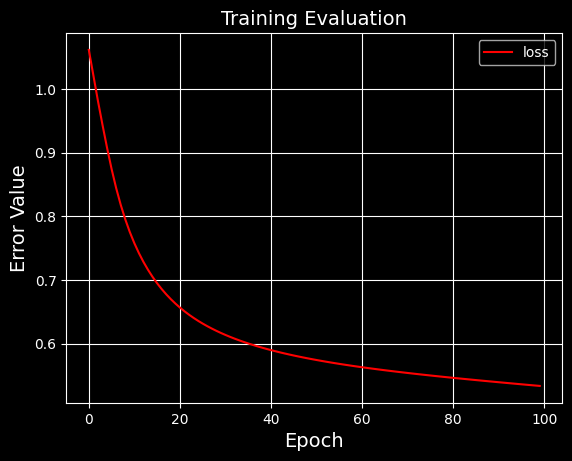

In [20]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**J. Validating Network Performance**

In [21]:
model = NeuralNetwork(5000,3)
state = torch.load("./torch_models/model_0.pth")
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [22]:
predictions_after = model.forward(torch.Tensor(X_val_vec))
#predictions_after = torch.argmax(predictions_after)
#predictions_after

In [23]:
predictions_after = torch.softmax(predictions_after, dim=1)

In [24]:
predictions = torch.argmax(predictions_after, dim=1)
predictions

tensor([1, 2, 1,  ..., 1, 2, 1])

In [25]:
#predictions_after = predictions_after.squeeze()
#predictions_after.shape

In [26]:
y_val_vec

tensor([1, 1, 2,  ..., 0, 2, 1])

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val_vec, predictions)
accuracy

0.6187720181177655

In [28]:
from sklearn.metrics import recall_score

recall_score = recall_score(y_val_vec, predictions, average='macro')
recall_score

0.5809644355110765

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_val_vec, predictions))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47      1208
           1       0.61      0.66      0.63      3529
           2       0.67      0.64      0.65      3211

    accuracy                           0.62      7948
   macro avg       0.60      0.58      0.59      7948
weighted avg       0.62      0.62      0.62      7948



Based on our experimentation on validation data, as can be seen in `Experiments.docx`, we have arrived at the following hyperparameters which produced the best results:

Number of Hidden Layers: 1 \
Number of Neurons in Hidden Layer: 50 \
Batch size: 128 \
Learning Rate: 0.0001 \
Function Loss: CrossEntropyLoss() \
Optimizer: Adam \
Number of Training Epochs: 100 

We will retrain our model using a much larger dataset using these hyperparameters.

**K. Retraining the Network**

In [30]:
X_full_train_vec = torch.from_numpy(X_full_train_vec).type(torch.float)
y_full_train = torch.from_numpy(y_full_train).type(torch.LongTensor)

X_test_vec = torch.from_numpy(X_test_vec).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [31]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class FullNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
    
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y


In [32]:
# Create an instance of the model and send it to target device
model_1 = FullNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_1

FullNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [33]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)
batch_size = 128

In [34]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [35]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer_1.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer_1.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_full_train_vec, y=y_full_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses_1 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_1,
        optimizer_1,
        loss_fn,
        batch_size
    )
    
    losses_1.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_1.state_dict() }
torch.save(state, "./torch_models/model_1.pth")

Epoch: 0


100%|██████████| 311/311 [00:02<00:00, 114.37it/s, loss=1.06]


Ave Loss: 1.088722270784654
Epoch: 1


100%|██████████| 311/311 [00:02<00:00, 127.83it/s, loss=0.994]


Ave Loss: 1.0269641956715723
Epoch: 2


100%|██████████| 311/311 [00:02<00:00, 131.43it/s, loss=0.943]


Ave Loss: 0.9713629160280013
Epoch: 3


100%|██████████| 311/311 [00:02<00:00, 129.72it/s, loss=0.892]


Ave Loss: 0.9248539989400907
Epoch: 4


100%|██████████| 311/311 [00:02<00:00, 132.63it/s, loss=0.843]


Ave Loss: 0.8818743916953108
Epoch: 5


100%|██████████| 311/311 [00:02<00:00, 130.10it/s, loss=0.799]


Ave Loss: 0.8447311070187682
Epoch: 6


100%|██████████| 311/311 [00:02<00:00, 134.33it/s, loss=0.76] 


Ave Loss: 0.813674900501104
Epoch: 7


100%|██████████| 311/311 [00:02<00:00, 133.00it/s, loss=0.726]


Ave Loss: 0.7878089849971882
Epoch: 8


100%|██████████| 311/311 [00:02<00:00, 138.82it/s, loss=0.697]


Ave Loss: 0.7661374851438394
Epoch: 9


100%|██████████| 311/311 [00:02<00:00, 135.22it/s, loss=0.67] 


Ave Loss: 0.7478273219617617
Epoch: 10


100%|██████████| 311/311 [00:02<00:00, 134.32it/s, loss=0.647]


Ave Loss: 0.7322278032348853
Epoch: 11


100%|██████████| 311/311 [00:02<00:00, 138.25it/s, loss=0.627]


Ave Loss: 0.718833190643519
Epoch: 12


100%|██████████| 311/311 [00:02<00:00, 139.76it/s, loss=0.608]


Ave Loss: 0.7072448793714836
Epoch: 13


100%|██████████| 311/311 [00:02<00:00, 139.23it/s, loss=0.592]


Ave Loss: 0.6971506332661178
Epoch: 14


100%|██████████| 311/311 [00:02<00:00, 120.36it/s, loss=0.577]


Ave Loss: 0.6882960276971676
Epoch: 15


100%|██████████| 311/311 [00:02<00:00, 115.03it/s, loss=0.563]


Ave Loss: 0.6804781776532483
Epoch: 16


100%|██████████| 311/311 [00:02<00:00, 120.25it/s, loss=0.551]


Ave Loss: 0.6735301648305544
Epoch: 17


100%|██████████| 311/311 [00:02<00:00, 116.87it/s, loss=0.54] 


Ave Loss: 0.6673185821514804
Epoch: 18


100%|██████████| 311/311 [00:02<00:00, 114.60it/s, loss=0.529]


Ave Loss: 0.6617349253973394
Epoch: 19


100%|██████████| 311/311 [00:02<00:00, 121.78it/s, loss=0.52] 


Ave Loss: 0.6566901506909987
Epoch: 20


100%|██████████| 311/311 [00:02<00:00, 124.26it/s, loss=0.511]


Ave Loss: 0.6521108715863857
Epoch: 21


100%|██████████| 311/311 [00:02<00:00, 118.85it/s, loss=0.503]


Ave Loss: 0.6479366446614648
Epoch: 22


100%|██████████| 311/311 [00:02<00:00, 129.01it/s, loss=0.495]


Ave Loss: 0.6441152502102867
Epoch: 23


100%|██████████| 311/311 [00:02<00:00, 125.63it/s, loss=0.488]


Ave Loss: 0.6406047599108656
Epoch: 24


100%|██████████| 311/311 [00:02<00:00, 133.29it/s, loss=0.482]


Ave Loss: 0.6373681025489734
Epoch: 25


100%|██████████| 311/311 [00:02<00:00, 129.30it/s, loss=0.476]


Ave Loss: 0.6343728043258765
Epoch: 26


100%|██████████| 311/311 [00:02<00:00, 123.08it/s, loss=0.47] 


Ave Loss: 0.6315922744787774
Epoch: 27


100%|██████████| 311/311 [00:02<00:00, 128.14it/s, loss=0.465]


Ave Loss: 0.6290050903125591
Epoch: 28


100%|██████████| 311/311 [00:02<00:00, 111.52it/s, loss=0.46] 


Ave Loss: 0.6265908059008252
Epoch: 29


100%|██████████| 311/311 [00:02<00:00, 128.62it/s, loss=0.455]


Ave Loss: 0.6243330967579623
Epoch: 30


100%|██████████| 311/311 [00:02<00:00, 133.41it/s, loss=0.451]


Ave Loss: 0.6222174732056461
Epoch: 31


100%|██████████| 311/311 [00:02<00:00, 133.24it/s, loss=0.446]


Ave Loss: 0.6202285263891005
Epoch: 32


100%|██████████| 311/311 [00:02<00:00, 135.23it/s, loss=0.442]


Ave Loss: 0.6183542450141294
Epoch: 33


100%|██████████| 311/311 [00:02<00:00, 140.72it/s, loss=0.439]


Ave Loss: 0.6165851460967416
Epoch: 34


100%|██████████| 311/311 [00:02<00:00, 140.43it/s, loss=0.435]


Ave Loss: 0.6149116137403384
Epoch: 35


100%|██████████| 311/311 [00:02<00:00, 140.79it/s, loss=0.432]


Ave Loss: 0.6133250509810985
Epoch: 36


100%|██████████| 311/311 [00:02<00:00, 123.20it/s, loss=0.429]


Ave Loss: 0.6118177937349706
Epoch: 37


100%|██████████| 311/311 [00:02<00:00, 110.87it/s, loss=0.426]


Ave Loss: 0.6103836631468255
Epoch: 38


100%|██████████| 311/311 [00:02<00:00, 113.93it/s, loss=0.423]


Ave Loss: 0.609016642788982
Epoch: 39


100%|██████████| 311/311 [00:02<00:00, 118.95it/s, loss=0.42] 


Ave Loss: 0.6077114940647911
Epoch: 40


100%|██████████| 311/311 [00:02<00:00, 117.51it/s, loss=0.418]


Ave Loss: 0.6064635983809015
Epoch: 41


100%|██████████| 311/311 [00:02<00:00, 120.00it/s, loss=0.415]


Ave Loss: 0.6052681208615135
Epoch: 42


100%|██████████| 311/311 [00:02<00:00, 126.95it/s, loss=0.413]


Ave Loss: 0.6041229897181705
Epoch: 43


100%|██████████| 311/311 [00:02<00:00, 126.72it/s, loss=0.411]


Ave Loss: 0.6030227071410973
Epoch: 44


100%|██████████| 311/311 [00:02<00:00, 130.69it/s, loss=0.408]


Ave Loss: 0.6019647242171972
Epoch: 45


100%|██████████| 311/311 [00:02<00:00, 130.82it/s, loss=0.406]


Ave Loss: 0.6009461369928439
Epoch: 46


100%|██████████| 311/311 [00:02<00:00, 126.85it/s, loss=0.404]


Ave Loss: 0.5999644914240699
Epoch: 47


100%|██████████| 311/311 [00:02<00:00, 130.26it/s, loss=0.403]


Ave Loss: 0.599016638718234
Epoch: 48


100%|██████████| 311/311 [00:02<00:00, 130.56it/s, loss=0.401]


Ave Loss: 0.5981005467594245
Epoch: 49


100%|██████████| 311/311 [00:02<00:00, 131.45it/s, loss=0.399]


Ave Loss: 0.5972149503384372
Epoch: 50


100%|██████████| 311/311 [00:02<00:00, 131.58it/s, loss=0.397]


Ave Loss: 0.5963569122495376
Epoch: 51


100%|██████████| 311/311 [00:02<00:00, 128.93it/s, loss=0.396]


Ave Loss: 0.5955246619856243
Epoch: 52


100%|██████████| 311/311 [00:02<00:00, 132.67it/s, loss=0.394]


Ave Loss: 0.594716043430126
Epoch: 53


100%|██████████| 311/311 [00:02<00:00, 131.87it/s, loss=0.393]


Ave Loss: 0.5939300530784767
Epoch: 54


100%|██████████| 311/311 [00:02<00:00, 131.34it/s, loss=0.391]


Ave Loss: 0.5931661680963645
Epoch: 55


100%|██████████| 311/311 [00:02<00:00, 125.30it/s, loss=0.39] 


Ave Loss: 0.5924233024718294
Epoch: 56


100%|██████████| 311/311 [00:02<00:00, 134.18it/s, loss=0.389]


Ave Loss: 0.5916989323985539
Epoch: 57


100%|██████████| 311/311 [00:02<00:00, 131.45it/s, loss=0.388]


Ave Loss: 0.5909914508509866
Epoch: 58


100%|██████████| 311/311 [00:02<00:00, 130.67it/s, loss=0.386]


Ave Loss: 0.5902996666945062
Epoch: 59


100%|██████████| 311/311 [00:02<00:00, 131.61it/s, loss=0.385]


Ave Loss: 0.589623509208489
Epoch: 60


100%|██████████| 311/311 [00:02<00:00, 127.73it/s, loss=0.384]


Ave Loss: 0.5889619838003177
Epoch: 61


100%|██████████| 311/311 [00:02<00:00, 131.28it/s, loss=0.383]


Ave Loss: 0.5883133719013435
Epoch: 62


100%|██████████| 311/311 [00:02<00:00, 131.70it/s, loss=0.382]


Ave Loss: 0.5876792212199552
Epoch: 63


100%|██████████| 311/311 [00:02<00:00, 131.08it/s, loss=0.381]


Ave Loss: 0.587056190254604
Epoch: 64


100%|██████████| 311/311 [00:02<00:00, 133.43it/s, loss=0.38] 


Ave Loss: 0.586443433615939
Epoch: 65


100%|██████████| 311/311 [00:02<00:00, 126.67it/s, loss=0.379]


Ave Loss: 0.5858412311199777
Epoch: 66


100%|██████████| 311/311 [00:02<00:00, 121.39it/s, loss=0.378]


Ave Loss: 0.5852491984988332
Epoch: 67


100%|██████████| 311/311 [00:02<00:00, 118.34it/s, loss=0.377]


Ave Loss: 0.584665693941607
Epoch: 68


100%|██████████| 311/311 [00:02<00:00, 119.15it/s, loss=0.376]


Ave Loss: 0.5840916146802749
Epoch: 69


100%|██████████| 311/311 [00:02<00:00, 125.40it/s, loss=0.376]


Ave Loss: 0.5835269595649082
Epoch: 70


100%|██████████| 311/311 [00:02<00:00, 117.56it/s, loss=0.375]


Ave Loss: 0.5829690682351397
Epoch: 71


100%|██████████| 311/311 [00:02<00:00, 113.14it/s, loss=0.374]


Ave Loss: 0.582419095890315
Epoch: 72


100%|██████████| 311/311 [00:02<00:00, 120.66it/s, loss=0.373]


Ave Loss: 0.5818759019926814
Epoch: 73


100%|██████████| 311/311 [00:02<00:00, 120.45it/s, loss=0.372]


Ave Loss: 0.5813402159804316
Epoch: 74


100%|██████████| 311/311 [00:02<00:00, 111.45it/s, loss=0.372]


Ave Loss: 0.5808088245690827
Epoch: 75


100%|██████████| 311/311 [00:02<00:00, 120.18it/s, loss=0.371]


Ave Loss: 0.5802843103071501
Epoch: 76


100%|██████████| 311/311 [00:02<00:00, 124.36it/s, loss=0.37] 


Ave Loss: 0.5797648360874875
Epoch: 77


100%|██████████| 311/311 [00:02<00:00, 124.96it/s, loss=0.369]


Ave Loss: 0.5792516242844499
Epoch: 78


100%|██████████| 311/311 [00:02<00:00, 125.67it/s, loss=0.369]


Ave Loss: 0.5787440389873897
Epoch: 79


100%|██████████| 311/311 [00:02<00:00, 129.29it/s, loss=0.368]


Ave Loss: 0.5782392961227626
Epoch: 80


100%|██████████| 311/311 [00:02<00:00, 128.60it/s, loss=0.367]


Ave Loss: 0.5777396534800147
Epoch: 81


100%|██████████| 311/311 [00:02<00:00, 131.14it/s, loss=0.367]


Ave Loss: 0.5772442443002842
Epoch: 82


100%|██████████| 311/311 [00:02<00:00, 129.23it/s, loss=0.366]


Ave Loss: 0.5767533314381381
Epoch: 83


100%|██████████| 311/311 [00:02<00:00, 125.65it/s, loss=0.366]


Ave Loss: 0.576264441684128
Epoch: 84


100%|██████████| 311/311 [00:02<00:00, 130.59it/s, loss=0.365]


Ave Loss: 0.5757805619784107
Epoch: 85


100%|██████████| 311/311 [00:02<00:00, 130.39it/s, loss=0.364]


Ave Loss: 0.5752983808134147
Epoch: 86


100%|██████████| 311/311 [00:02<00:00, 127.39it/s, loss=0.364]


Ave Loss: 0.5748187834426904
Epoch: 87


100%|██████████| 311/311 [00:02<00:00, 113.61it/s, loss=0.363]


Ave Loss: 0.5743411030991667
Epoch: 88


100%|██████████| 311/311 [00:02<00:00, 113.95it/s, loss=0.363]


Ave Loss: 0.5738669255347114
Epoch: 89


100%|██████████| 311/311 [00:02<00:00, 104.13it/s, loss=0.362]


Ave Loss: 0.5733936715547678
Epoch: 90


100%|██████████| 311/311 [00:03<00:00, 101.80it/s, loss=0.362]


Ave Loss: 0.5729232811851134
Epoch: 91


100%|██████████| 311/311 [00:02<00:00, 114.50it/s, loss=0.361]


Ave Loss: 0.572453631465458
Epoch: 92


100%|██████████| 311/311 [00:02<00:00, 114.23it/s, loss=0.361]


Ave Loss: 0.5719840237182053
Epoch: 93


100%|██████████| 311/311 [00:02<00:00, 113.44it/s, loss=0.36] 


Ave Loss: 0.5715154223503407
Epoch: 94


100%|██████████| 311/311 [00:02<00:00, 112.63it/s, loss=0.36] 


Ave Loss: 0.571048505628224
Epoch: 95


100%|██████████| 311/311 [00:02<00:00, 112.47it/s, loss=0.359]


Ave Loss: 0.5705823390430192
Epoch: 96


100%|██████████| 311/311 [00:02<00:00, 116.02it/s, loss=0.359]


Ave Loss: 0.5701180477042673
Epoch: 97


100%|██████████| 311/311 [00:02<00:00, 113.96it/s, loss=0.358]


Ave Loss: 0.5696501251777268
Epoch: 98


100%|██████████| 311/311 [00:02<00:00, 109.11it/s, loss=0.358]


Ave Loss: 0.5691825670828007
Epoch: 99


100%|██████████| 311/311 [00:02<00:00, 113.08it/s, loss=0.357]

Ave Loss: 0.5687135558611327
Training duration: 249.9541585445404 seconds


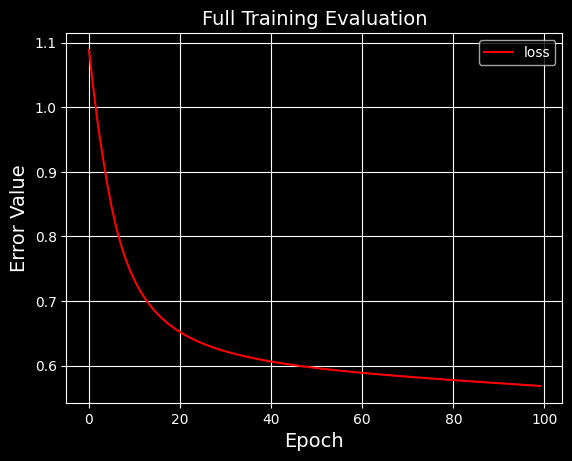

In [36]:
plt.plot(losses_1, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [37]:
model_1 = FullNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_1.pth")
model_1.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [38]:
predictions_1 = model_1.forward(X_test_vec)
predictions_1 = torch.softmax(predictions_1, dim=1)
predictions_1 = torch.argmax(predictions_1, dim=1)
predictions_1

tensor([1, 2, 2,  ..., 1, 1, 1])

In [39]:
y_test.shape

torch.Size([9935])

In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions_1)
accuracy

0.6370407649723201

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_1))

              precision    recall  f1-score   support

           0       0.54      0.47      0.50      1550
           1       0.63      0.68      0.65      4451
           2       0.68      0.66      0.67      3934

    accuracy                           0.64      9935
   macro avg       0.62      0.60      0.61      9935
weighted avg       0.64      0.64      0.64      9935



Our final model performance are as follows:

**Macro-Recall** - 0.60 \
**Macro-F1** - 0.61     
**Accuracy** - 0.64

**We will try to improve the performance of `model_1` by resampling the population of our minority `negative` class using Variational AutoEncoder.**

In [42]:
torch.save(y_test, 'tensors/y_test.pt')

In [43]:
torch.save(X_test_vec,'tensors/X_test_vec.pt')

#### **End. Thank you!**